# Project - Hand Written Character Classification - Neural Networks

# Data set setup

In [6]:
import scipy.io

# prereqs import
import pandas as pd
import numpy as np
import math
import re
#from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

# load matlab data
mat = scipy.io.loadmat('matlab/emnist-balanced')
mat.keys()
data = mat['dataset']

# see page 4 of the paper on emnist
# uncertain what 3rd entry is in dataset
X_train = data['train'][0,0]['images'][0,0]
y_train = data['train'][0,0]['labels'][0,0]
X_test = data['test'][0,0]['images'][0,0]
y_test = data['test'][0,0]['labels'][0,0]

# try proccessing data (pixel values from EMINST are not normalized, 0-255)
def rescale_DivideBy255(inputData):
    outputArray = []
    for i in range(len(inputData)):
        outputArray.append(inputData[i]/255)

    return outputArray

X_train_normalized = rescale_DivideBy255(X_train)
X_test_normalized = rescale_DivideBy255(X_test)

train_data = X_train_normalized
train_target = y_train
test_data = X_test_normalized
test_target = y_test

In [7]:
# kfold cross validation
# returns an array indicating accuracy of each algorithm
# Each indicey result computing cross validation error and averaging across number of folds for each algorithm
# Throwing future depreciation warnings because of np.array split on pandas data frame.
def kfoldCrossValidation(n_folds=(),algorithms=(),data=(),target=()):
    # Perform k fold cross validation
    # 1. partition data into k disjoint subsets
    # np_partitionsData = np.array(inputData)[:,None]
    partitionsData = np.array_split(data,n_folds)
    #np_partitionsTarget = np.array(inputData)[:,None]
    partitionsTarget = np.array_split(target,n_folds)

    hypotheses = [[0]*n_folds for m in range(len(algorithms))]
    accuracy = [[0]*n_folds for m in range(len(algorithms))]

    # 2. Compute accuracy for each algorithm on each fold
    for i in range(n_folds):
        # Get training set given current fold i
        curTrainingSetParts = []
        curTargetSetParts = []
        for j in range(n_folds):
            if(j!=i):
                curTrainingSetParts.append(partitionsData[j])
                curTargetSetParts.append(partitionsTarget[j])

        curTrainingSet = np.concatenate(curTrainingSetParts)
        curTargetSet = np.concatenate(curTargetSetParts)

        # run all learning algorithms Am on the training set, store hypothesis hmj
        for m in range(len(algorithms)):
            hypotheses[m][i] = algorithms[m].fit(curTrainingSet,curTargetSet)
            accuracy[m][i] = hypotheses[m][i].score(partitionsData[i],partitionsTarget[i])

    # 3. Return the average accuracy of each algorithm
    alg_accuracy = []
    for m in range(len(algorithms)):
        mRisk = 0
        for score in accuracy[m]:
            mRisk+=score

        mRisk/= n_folds
        alg_accuracy.append(mRisk)

    return alg_accuracy

# disable warnings in following code
import warnings
warnings.filterwarnings('ignore')

# Test Neural Network Training
train time:
- 73~ minutes to train on non normalized data
- 9 minute train time normalized data
- 22 minutes training on balanced normalized data

accuracy:
- 0.97 accuracy classifying non normalized data [DIGITS]
- 0.9862 accuracy classifying normalized data [DIGITS]
- accuracy classifying normalized [BALANCED] dataset
- 79% accuracy classifying the balanced data set <- room for tuning

In [4]:
# For digits expect 280,000 total samples, 240,000 for training, 40,000 for testing. 
len(X_train_normalized)

112800

In [5]:
from sklearn import neural_network

testNN = neural_network.MLPClassifier()
testNN.fit(X_train_normalized,y_train)

MLPClassifier()

In [22]:

testNN.score(X_test_normalized,y_test)

0.7954255319148936

# Neural Network Experiments

## 1 - Tuning Parameters

### 1.1 - Node Type
Using defaults of sci kit learn MLP. Varry node type and compare accuracy on the training set with kfold cross validation.

In [11]:
from sklearn import neural_network

node_types = ['identity', 'logistic','relu','tanh']

accuracy_kcv_tuning_nodeType = []

for node_type in node_types:
    nn_characterClassifier = neural_network.MLPClassifier(activation=node_type)
    nn_characterClassifier.fit(train_data,train_target)
    accuracy_kcv_tuning_nodeType.append(
        [
            node_type,
            kfoldCrossValidation(n_folds=5,algorithms=[nn_characterClassifier],data=train_data,target=train_target)
         ]
        )

In [12]:
errors = np.array(accuracy_kcv_tuning_nodeType, dtype="object")
errors = errors.T
xVals=[]
yVals=[]
for val in errors[0]:
    xVals.append(val)
for val in errors[1]:
    yVals.append(val)

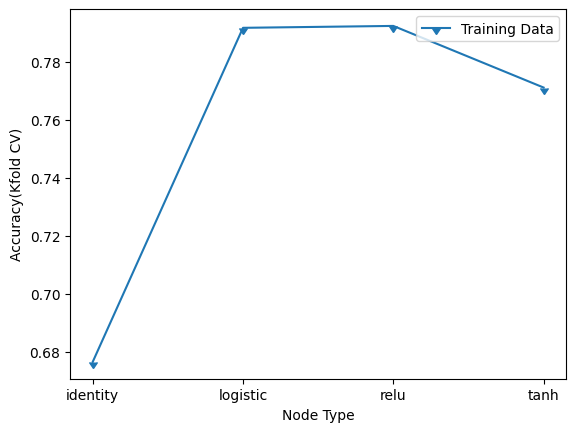

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("Node Type")
ax.set_ylabel("Accuracy(Kfold CV)")
ax.plot(xVals, yVals,label="Training Data",marker=11)
ax.legend(loc='upper right')
plt.show()

## 1.2 - Hidden Layer size
Try a single hidden layer, plot kcv accuracy vs number of nodes. Use default relu node type

In [6]:
# hidden layer sizes
initial_size = 5
hl_size_max = 100 
hidden_layer_sizes_layers = []

for i in range(10,202,40):
    hidden_layer_sizes_layers.append((i,))

#hidden_layer_sizes_layers
hidden_layer_sizes_layers

[(10,), (50,), (90,), (130,), (170,)]

In [7]:
from sklearn import neural_network
#350 minutes to train
accuracy_kcv_tuning_hiddenLayerSize_l1 = []

for layer in hidden_layer_sizes_layers:
    nn_characterClassifier = neural_network.MLPClassifier(hidden_layer_sizes=layer,activation='relu')
    nn_characterClassifier.fit(train_data,train_target)
    accuracy_kcv_tuning_hiddenLayerSize_l1.append(
        [
            layer[0],
            kfoldCrossValidation(n_folds=5,algorithms=[nn_characterClassifier],data=train_data,target=train_target)
         ]
        )

In [10]:
errors = np.array(accuracy_kcv_tuning_hiddenLayerSize_l1, dtype="object")
errors = errors.T
xVals=[]
yVals=[]
for val in errors[0]:
    xVals.append(val)
for val in errors[1]:
    yVals.append(val)

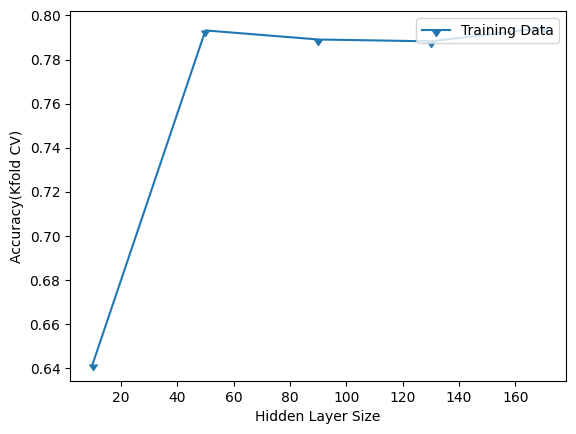

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel("Hidden Layer Size")
ax.set_ylabel("Accuracy(Kfold CV)")
ax.plot(xVals, yVals,label="Training Data",marker=11)
ax.legend(loc='upper right')
plt.show()

## 1.3 - Hidden Layer Number = 2

In [1]:
# hidden layer sizes
initial_size = 5
hl_size_max = 100 
hidden_layer_sizes_layers = []

for i in range(10,202,40):
    hidden_layer_sizes_layers.append((i,i))

#hidden_layer_sizes_layers
hidden_layer_sizes_layers

[(10, 10), (50, 50), (90, 90), (130, 130), (170, 170)]

In [4]:
from sklearn import neural_network
#350 minutes to train
accuracy_kcv_tuning_hiddenLayerSize_l2 = []

for layer in hidden_layer_sizes_layers:
    nn_characterClassifier = neural_network.MLPClassifier(hidden_layer_sizes=layer,activation='relu')
    nn_characterClassifier.fit(train_data,train_target)
    accuracy_kcv_tuning_hiddenLayerSize_l2.append(
        [
            layer[0],
            kfoldCrossValidation(n_folds=5,algorithms=[nn_characterClassifier],data=train_data,target=train_target)
         ]
        )

In [5]:
errors = np.array(accuracy_kcv_tuning_hiddenLayerSize_l2, dtype="object")
errors = errors.T
xVals=[]
yVals=[]
for val in errors[0]:
    xVals.append(val)
for val in errors[1]:
    yVals.append(val)

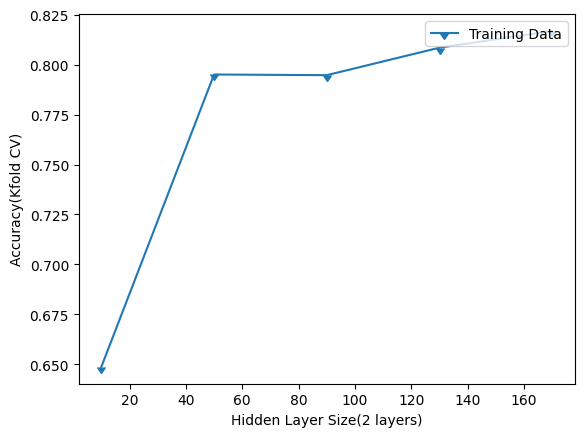

: 

In [6]:
fig, ax = plt.subplots()
ax.set_xlabel("Hidden Layer Size(2 layers)")
ax.set_ylabel("Accuracy(Kfold CV)")
ax.plot(xVals, yVals,label="Training Data",marker=11)
ax.legend(loc='upper right')
plt.show()

# Tuning Number of layers (size 200)

In [4]:
# hidden layer sizes
initial_size = 5
hl_size_max = 100 
hidden_layer_sizes_layers = []

for i in range(1,7,2):
    layer = tuple(200 for _ in range(i))
    hidden_layer_sizes_layers.append(layer)

hidden_layer_sizes_layers
#len(hidden_layer_sizes_layers[2])

[(200,), (200, 200, 200), (200, 200, 200, 200, 200)]

In [8]:
from sklearn import neural_network
accuracy_kcv_tuning_hiddenLayerNumber_1 = []

for layer in hidden_layer_sizes_layers:
    nn_characterClassifier = neural_network.MLPClassifier(hidden_layer_sizes=layer,activation='relu')
    nn_characterClassifier.fit(train_data,train_target)
    accuracy_kcv_tuning_hiddenLayerNumber_1.append(
        [
            len(layer),
            kfoldCrossValidation(n_folds=5,algorithms=[nn_characterClassifier],data=train_data,target=train_target)
         ]
        )

In [10]:
errors = np.array(accuracy_kcv_tuning_hiddenLayerNumber_1, dtype="object")
errors = errors.T
xVals=[]
yVals=[]
for val in errors[0]:
    xVals.append(val)
for val in errors[1]:
    yVals.append(val)

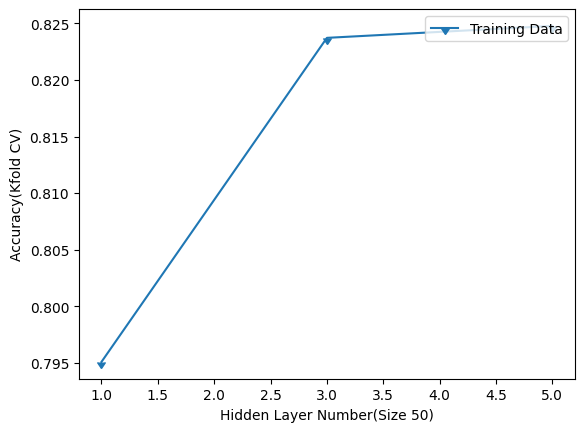

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel("Hidden Layer Number(Size 50)")
ax.set_ylabel("Accuracy(Kfold CV)")
ax.plot(xVals, yVals,label="Training Data",marker=11)
ax.legend(loc='upper right')
plt.show()

# Scatter shot
Try variety of NN configurations and compare kCV accuracy

## very large hidden layer 1(1000)

In [8]:
from sklearn import neural_network

nn_characterClassifier = neural_network.MLPClassifier(hidden_layer_sizes=(1000,),activation='relu')
nn_characterClassifier.fit(train_data,train_target)
result=kfoldCrossValidation(n_folds=5,algorithms=[nn_characterClassifier],data=train_data,target=train_target)
result